# Image Classification: Detecting Pediatric Pneumonia

## Overview
Pneumonia is an infection in one or both lungs which makes people have difficulty breathing. It can be a medical emergency, especially among high-risk groups like people over 65 and children 5 or younger, whose immune systems are relatively weaker. Therefore, it is crucial to identify pneumonia in a more efficient and accurate way, so that we can have treatment in the early stage.

## Business Understanding

![](Images/pneumonia-death-rates-in-children-under-5.svg)

According to the World Health Organization, there are 156 million cases of pneumonia each year in children younger than five years. It is a serious illness, especially in young children whose immune systems have not fully developed yet.

Pneumonia continues to be one of the leading causes of death among children across the globe. The death rates for pneumonia are highest in South Asia and sub-Saharan Africa. According to Unicef, almost 800,000 children died in 2019 from pneumonia, and pneumonia accounts for 14% of all deaths among children 5 years and younger. Given these sobering statistics, it is vital that doctors can quickly identify those with pneumonia to treat it as soon as possible. As the WHO explains, “effective diagnosis and treatment of pneumonia is critical to improve child survival.”

"The deaths in just 5 countries — India, Nigeria, Pakistan, the Democratic Republic of Congo, and Ethiopia – accounted for more than half of all deaths from childhood pneumonia in 2019." (https://ourworldindata.org/pneumonia)

To make the diagnosis process more efficient and accurate, we're going to build a machine learning model that can identify whether the input X-ray image is pneumonia or not. Once we have our model, we will cooperate with the WHO to deploy our model in areas around the world that need this help the most.

## Data Understanding
For this project, we worked with 6000 chest X-ray images of pediatric patients from one to five years old found from ["Kaggle"](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). This data was collected from the Guangzhou Women and Children's Medical Center in Guangzhou, China. The data has already been split into training, validation and testing sets, but the validation set was extremely small (8 images), so we combined all images into one folder and performed our own train, validation, test split. Approximately 75% of the images in our dataset belonged to those with pneumonia. Given that our dataset is images, there was very little data cleaning to perform, and we were able to jump straight into creating our neural network for classification of chest x-ray images. 

## Data Preparation

In [1]:
#importing packages


import numpy as np
import tensorflow as tf
import random as python_random

import pandas as pd 
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
import os

from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import load_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, classification_report, precision_score
from sklearn.model_selection import cross_val_score
from tensorflow.keras import metrics
from tensorflow.keras.wrappers import scikit_learn

from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
# use the splitfolders package to split our image data into train, validation, and test sets.
# this is now commented out so that we don't create a new folder each time we run the notebook


# splitfolders.ratio("Data", output="Data_Split",
# seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [4]:
# using ImageDataGenerator to rescale all images 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4280,
        color_mode='grayscale',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 3749 images belonging to 2 classes.


In [6]:
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=978,
                                                        color_mode='grayscale',
                                                        class_mode='binary')
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 936 images belonging to 2 classes.
Found 1107 images belonging to 2 classes.


In [7]:
#Creating the augumented data
aug_train_images = ImageDataGenerator(rotation_range=30, 
                                   width_shift_range=0.25, 
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_aug = aug_train_images.flow_from_directory('Data_Split/train',
                                                  target_size=(150, 150),
                                                  batch_size=3747,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 3749 images belonging to 2 classes.


In [8]:
#getting images and labels for models
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [9]:
#reshaping for our Simple Model - dimension needs to be 2D 
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
val_data = val_data.reshape(val_data.shape[0], -1)
train_data.shape

(3749, 22500)

In [10]:
# Function to show confusion matrix 
##from sklearn
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Dummy Model
We will use a dummy model classifier as our baseline model. This model will predict the majority class. Since the majority class in our data is pneumonia, this model will predict all images are pneumonia.

In [11]:
# instantiate our DummyModel and fit to train dataset
dummy_model =  DummyClassifier(strategy='most_frequent')
dummy_model.fit(train_data, train_labels)

DummyClassifier(strategy='most_frequent')

In [12]:
# creating predictions to evalaute model 
y_pred = (dummy_model.predict(val_data))

In [13]:
# getting metrics for model
dummy_acc = dummy_model.score(val_data, val_labels)
dummy_rec = recall_score(val_labels,y_pred)
dummy_pre = precision_score(val_labels,y_pred)

print(f"Dummy Model accuracy: {dummy_acc}")
print(f"Dummy Model recall: {dummy_rec}")
print(f"Dummy Model precision: {dummy_pre}")

Dummy Model accuracy: 0.7297008547008547
Dummy Model recall: 1.0
Dummy Model precision: 0.7297008547008547


Confusion matrix, without normalization
[[  0 253]
 [  0 683]]


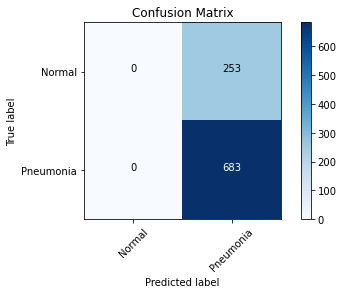

In [14]:
# creating confusion matrix
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

### Simple Model 1
Our first model will be a simple model - this will give us an idea of what parameters we can use to tweak model performance.

In [15]:
# instantiating neural network model
simple_model = models.Sequential()

In [16]:
# giving input and output layers
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid')) 

In [17]:
# compiling model and printing summary
simple_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                270012    
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [18]:
# training our simple model and validating using out subset of validation data
simple_model_history = simple_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 4s 20ms/step - loss: 0.6082 - accuracy: 0.7263 - precision: 0.7306 - recall: 0.9901 - val_loss: 0.4774 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/10
118/118 [==============================] - 1s 10ms/step - loss: 0.4252 - accuracy: 0.7330 - precision: 0.7323 - recall: 0.9996 - val_loss: 0.4091 - val_accuracy: 0.8857 - val_precision: 0.9235 - val_recall: 0.9195
Epoch 3/10
118/118 [==============================] - 2s 13ms/step - loss: 0.3561 - accuracy: 0.8618 - precision: 0.8622 - recall: 0.9649 - val_loss: 0.3371 - val_accuracy: 0.8472 - val_precision: 0.8301 - val_recall: 0.9941
Epoch 4/10
118/118 [==============================] - 1s 9ms/step - loss: 0.3357 - accuracy: 0.8834 - precision: 0.8906 - recall: 0.9580 - val_loss: 0.3015 - val_accuracy: 0.8857 - val_precision: 0.8750 - val_recall: 0.9839
Epoch 5/10
118/118 [==============================] - 1s 9ms/step - loss: 0.3077 - accuracy: 0.8984 -

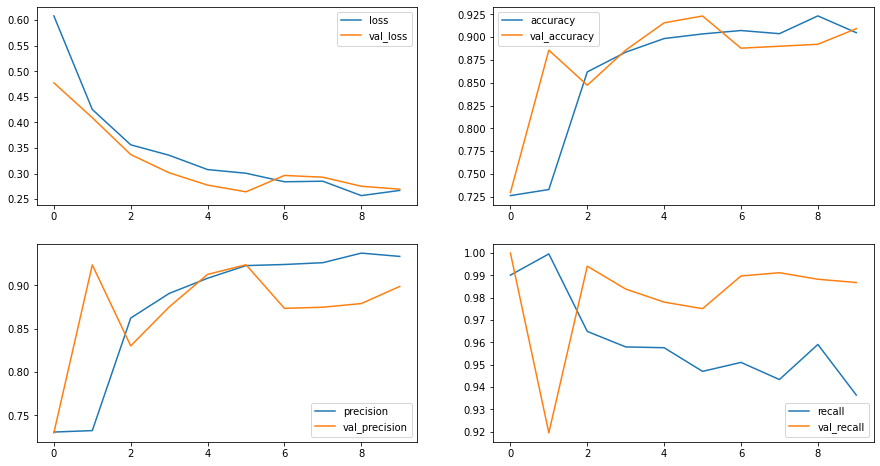

In [19]:
#visualizing metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

loss = simple_model_history.history['loss']
accuracy = simple_model_history.history['accuracy']
precision = simple_model_history.history['precision']
recall = simple_model_history.history['recall']

validation_loss = simple_model_history.history['val_loss']
validation_accuracy = simple_model_history.history['val_accuracy']
validation_precision = simple_model_history.history['val_precision']
validation_recall = simple_model_history.history['val_recall']

sns.lineplot(simple_model_history.epoch, simple_model_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');



In [20]:
# creating predictions to test model metrics against validation data
y_pred = (simple_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 

30/30 [==============================] - 0s 5ms/step


Confusion matrix, without normalization
[[177  76]
 [  9 674]]


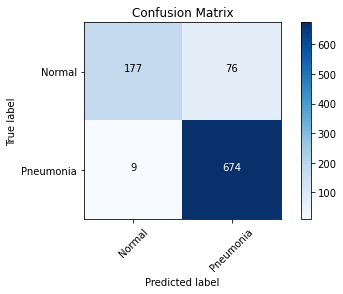

In [21]:
# visualizing confusion matrix
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [22]:
# evaluating model
results = simple_model.evaluate(val_data, val_labels)

30/30 [==============================] - 0s 4ms/step - loss: 0.2694 - accuracy: 0.9092 - precision: 0.8987 - recall: 0.9868


In [23]:
# getting model metrics
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.26936620473861694
Model accuracy: 0.9091880321502686
Model precision: 0.8986666798591614
Model recall: 0.9868228435516357


Our first simple model performed well in regards to precision and accuracy. It performed especially well in regard to recall. Moving forward we plan to use Convolutional Neural Networks as they are able to pick up on patterns within images. 

### CNN Model 1

In [24]:
#currently our data is 2D for our Simple Model
#recreating data sets for our CNN models  - dimension needs to be 4D 
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [25]:
cnn1_model = models.Sequential()
cnn1_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                    input_shape=(150, 150, 1)))
cnn1_model.add(layers.MaxPooling2D((2, 2)))
cnn1_model.add(layers.Flatten())
cnn1_model.add(layers.Dense(16, activation='relu'))
cnn1_model.add(layers.Dense(1, activation='sigmoid'))

cnn1_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                5456912   
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,458,017
Trainable params: 5,458,017
Non-trainable params: 0
____________________________________________

In [26]:
cnn1_history = cnn1_model.fit(train_data,
               train_labels,
               batch_size=30,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
125/125 [==============================] - 81s 625ms/step - loss: 0.4432 - accuracy: 0.8128 - precision: 0.8049 - recall: 0.9814 - val_loss: 0.2897 - val_accuracy: 0.9135 - val_precision: 0.9090 - val_recall: 0.9795
Epoch 2/10
125/125 [==============================] - 78s 624ms/step - loss: 0.2843 - accuracy: 0.9136 - precision: 0.9164 - recall: 0.9700 - val_loss: 0.2830 - val_accuracy: 0.8985 - val_precision: 0.8848 - val_recall: 0.9898
Epoch 3/10
125/125 [==============================] - 85s 679ms/step - loss: 0.2553 - accuracy: 0.9379 - precision: 0.9402 - recall: 0.9770 - val_loss: 0.2683 - val_accuracy: 0.9103 - val_precision: 0.8956 - val_recall: 0.9927
Epoch 4/10
125/125 [==============================] - 141s 1s/step - loss: 0.2334 - accuracy: 0.9451 - precision: 0.9489 - recall: 0.9773 - val_loss: 0.2283 - val_accuracy: 0.9530 - val_precision: 0.9678 - val_recall: 0.9678
Epoch 5/10
125/125 [==============================] - 167s 1s/step - loss: 0.2125 - accuracy: 

In [27]:
#saving model to folder
cnn1_model.save('models/cnn1')

INFO:tensorflow:Assets written to: models/cnn1/assets


INFO:tensorflow:Assets written to: models/cnn1/assets


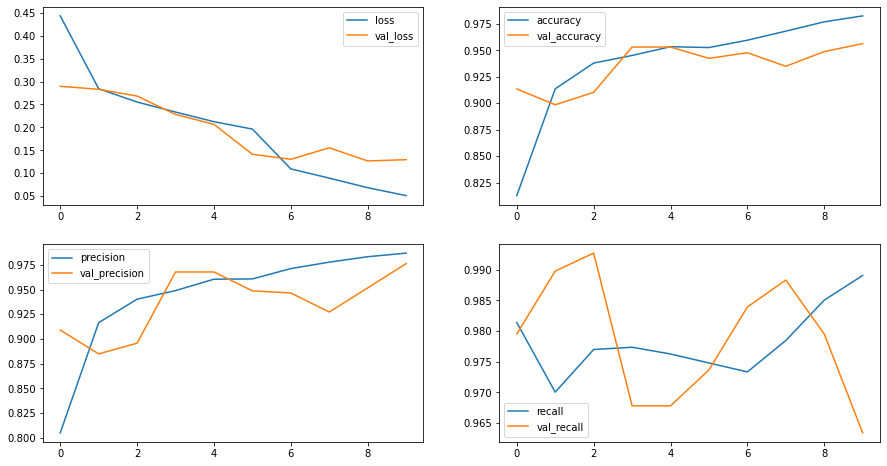

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn1_history.epoch, cnn1_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [29]:
y_pred = (cnn1_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 10s 305ms/step


Confusion matrix, without normalization
[[237  16]
 [ 25 658]]


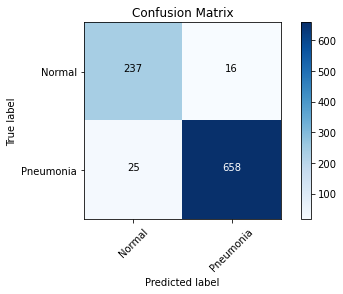

In [30]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [31]:
results = cnn1_model.evaluate(validation_generator)

1/1 [==============================] - 43s 43s/step - loss: 0.1295 - accuracy: 0.9562 - precision: 0.9763 - recall: 0.9634


In [32]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.12954507768154144
Model accuracy: 0.9561966061592102
Model precision: 0.9762611389160156
Model recall: 0.9633967876434326


Our first CNN model performed better than our simple model. Our Model loss is better in this modelOur accuracy increased from 90.9 to 95.6, while our precision increased 89.8 to 97.6, while our recall fell from 98.6 to 96.3. Lets add another Convolutional layer and decrease the filter from 4,4 to 3,3 in our first Convolutional layer. 

## CNN Model 2
description

In [33]:
cnn2_model = models.Sequential()
cnn2_model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                            input_shape=(150,150,1)))
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Flatten())
cnn2_model.add(Dense(16, activation='relu'))
cnn2_model.add(Dense(1, activation='sigmoid')) 

cnn2_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [34]:
cnn2_history = cnn2_model.fit(train_data,
               train_labels,
               batch_size=50,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
75/75 [==============================] - 214s 3s/step - loss: 0.3748 - accuracy: 0.8400 - precision: 0.8395 - recall: 0.9653 - val_loss: 0.2374 - val_accuracy: 0.8921 - val_precision: 0.8789 - val_recall: 0.9883
Epoch 2/10
75/75 [==============================] - 234s 3s/step - loss: 0.1667 - accuracy: 0.9354 - precision: 0.9495 - recall: 0.9627 - val_loss: 0.1387 - val_accuracy: 0.9455 - val_precision: 0.9476 - val_recall: 0.9795
Epoch 3/10
75/75 [==============================] - 216s 3s/step - loss: 0.1611 - accuracy: 0.9395 - precision: 0.9517 - recall: 0.9660 - val_loss: 0.1406 - val_accuracy: 0.9466 - val_precision: 0.9675 - val_recall: 0.9590
Epoch 4/10
75/75 [==============================] - 197s 3s/step - loss: 0.1357 - accuracy: 0.9485 - precision: 0.9602 - recall: 0.9697 - val_loss: 0.1123 - val_accuracy: 0.9476 - val_precision: 0.9662 - val_recall: 0.9619
Epoch 5/10
75/75 [==============================] - 209s 3s/step - loss: 0.1225 - accuracy: 0.9536 - precisi

In [35]:
cnn2_model.save('models/cnn2')

INFO:tensorflow:Assets written to: models/cnn2/assets


INFO:tensorflow:Assets written to: models/cnn2/assets


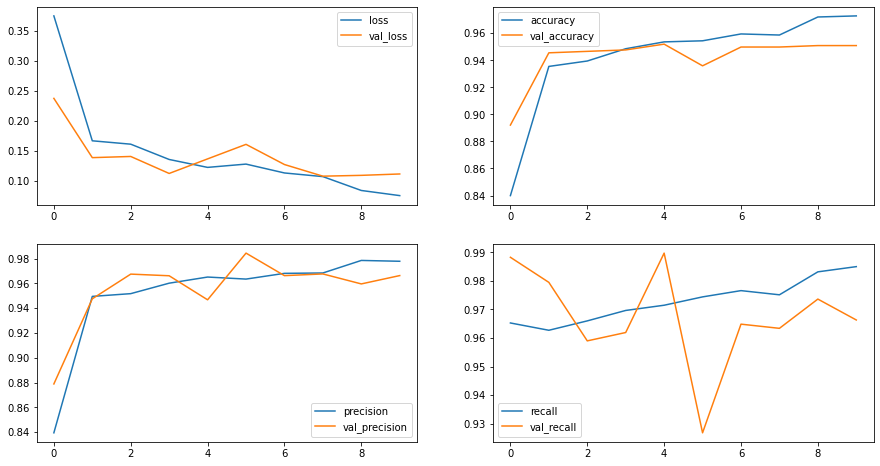

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn2_history.epoch, cnn2_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [37]:
y_pred = (cnn2_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 9s 290ms/step


Confusion matrix, without normalization
[[230  23]
 [ 23 660]]


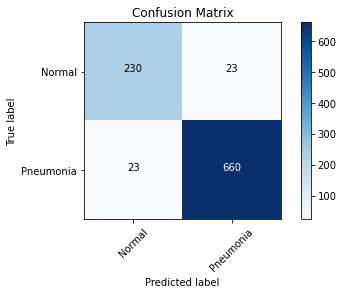

In [38]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [39]:
results = cnn2_model.evaluate(validation_generator)

1/1 [==============================] - 32s 32s/step - loss: 0.1115 - accuracy: 0.9509 - precision: 0.9663 - recall: 0.9663


In [40]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.11148016154766083
Model accuracy: 0.9508547186851501
Model precision: 0.966325044631958
Model recall: 0.966325044631958


Our second CNN model performed similar to our first model. Our accuracy decreased fractionally from 95.6 to 95.0, while our precision fell from 97.6 to 96.6, and our recall increased fractionally from 96.3 to 96.6. Lets revert back to the filter size 4,4 from our first cnn model while keeping the second Convolutional layer.

### CNN Model 3

In [41]:
cnn3_model = models.Sequential()
cnn3_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                      input_shape=(150, 150, 1)))
cnn3_model.add(layers.MaxPooling2D((2, 2)))
cnn3_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3_model.add(layers.MaxPooling2D((2,2)))
cnn3_model.add(layers.Flatten())
cnn3_model.add(layers.Dense(16, activation='relu'))
cnn3_model.add(layers.Dense(1, activation='sigmoid'))

cnn3_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 39200)             0         
                                                                 
 dense_6 (Dense)             (None, 16)               

In [42]:
cnn3_history = cnn3_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 134s 1s/step - loss: 0.2897 - accuracy: 0.8741 - precision: 0.8799 - recall: 0.9583 - val_loss: 0.1757 - val_accuracy: 0.9316 - val_precision: 0.9329 - val_recall: 0.9766
Epoch 2/10
118/118 [==============================] - 128s 1s/step - loss: 0.1697 - accuracy: 0.9403 - precision: 0.9483 - recall: 0.9711 - val_loss: 0.1416 - val_accuracy: 0.9455 - val_precision: 0.9759 - val_recall: 0.9488
Epoch 3/10
118/118 [==============================] - 128s 1s/step - loss: 0.1454 - accuracy: 0.9448 - precision: 0.9567 - recall: 0.9682 - val_loss: 0.1494 - val_accuracy: 0.9412 - val_precision: 0.9772 - val_recall: 0.9414
Epoch 4/10
118/118 [==============================] - 128s 1s/step - loss: 0.1256 - accuracy: 0.9541 - precision: 0.9648 - recall: 0.9726 - val_loss: 0.1331 - val_accuracy: 0.9455 - val_precision: 0.9451 - val_recall: 0.9824
Epoch 5/10
118/118 [==============================] - 130s 1s/step - loss: 0.1097 - accuracy: 0.9613

In [43]:
cnn3_model.save('models/cnn3')

INFO:tensorflow:Assets written to: models/cnn3/assets


INFO:tensorflow:Assets written to: models/cnn3/assets


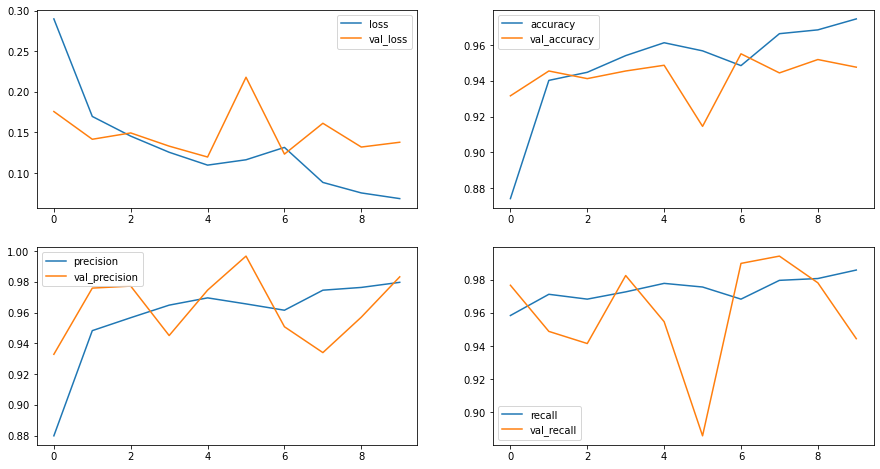

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn3_history.epoch, cnn3_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [45]:
y_pred = (cnn3_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 9s 289ms/step


Confusion matrix, without normalization
[[242  11]
 [ 38 645]]


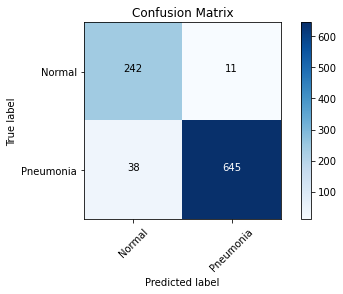

In [46]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [47]:
results = cnn3_model.evaluate(validation_generator)

1/1 [==============================] - 31s 31s/step - loss: 0.1379 - accuracy: 0.9476 - precision: 0.9832 - recall: 0.9444


In [48]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.13790251314640045
Model accuracy: 0.9476495981216431
Model precision: 0.9832317233085632
Model recall: 0.9443631172180176


Our third CNN model performed similar to our previous models. Our accuracy decreased fractionally from 95.0 to 94.7, while our precision increased from 96.6 to 98.3, and our recall fell from 96.6 to 94.4. We noticed that there was a bit of overfitting in our model. Lets add a regularizer onto our model to try and account for this. 

### CNN Model 4

In [49]:
cnn4_model = models.Sequential()
cnn4_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2, 2)))
cnn4_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2,2)))
cnn4_model.add(layers.Flatten())
cnn4_model.add(layers.Dense(16, activation='relu'))
cnn4_model.add(layers.Dense(1, activation='sigmoid'))

cnn4_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
cnn4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 39200)             0         
                                                                 
 dense_8 (Dense)             (None, 16)               

In [50]:
cnn4_history = cnn4_model.fit(train_data,
              train_labels,
              batch_size=32,
              epochs=10,
              validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 145s 1s/step - loss: 1.0907 - accuracy: 0.7941 - precision: 0.7855 - recall: 0.9876 - val_loss: 0.5943 - val_accuracy: 0.7799 - val_precision: 0.7683 - val_recall: 1.0000
Epoch 2/10
118/118 [==============================] - 138s 1s/step - loss: 0.4173 - accuracy: 0.8976 - precision: 0.8874 - recall: 0.9846 - val_loss: 0.3667 - val_accuracy: 0.9284 - val_precision: 0.9375 - val_recall: 0.9663
Epoch 3/10
118/118 [==============================] - 155s 1s/step - loss: 0.3418 - accuracy: 0.9090 - precision: 0.9033 - recall: 0.9803 - val_loss: 0.3373 - val_accuracy: 0.8761 - val_precision: 0.8548 - val_recall: 1.0000
Epoch 4/10
118/118 [==============================] - 151s 1s/step - loss: 0.3033 - accuracy: 0.9253 - precision: 0.9243 - recall: 0.9777 - val_loss: 0.2927 - val_accuracy: 0.9348 - val_precision: 0.9642 - val_recall: 0.9458
Epoch 5/10
118/118 [==============================] - 171s 1s/step - loss: 0.2780 - accuracy: 0.9354

In [51]:
cnn4_model.save('models/cnn4')

INFO:tensorflow:Assets written to: models/cnn4/assets


INFO:tensorflow:Assets written to: models/cnn4/assets


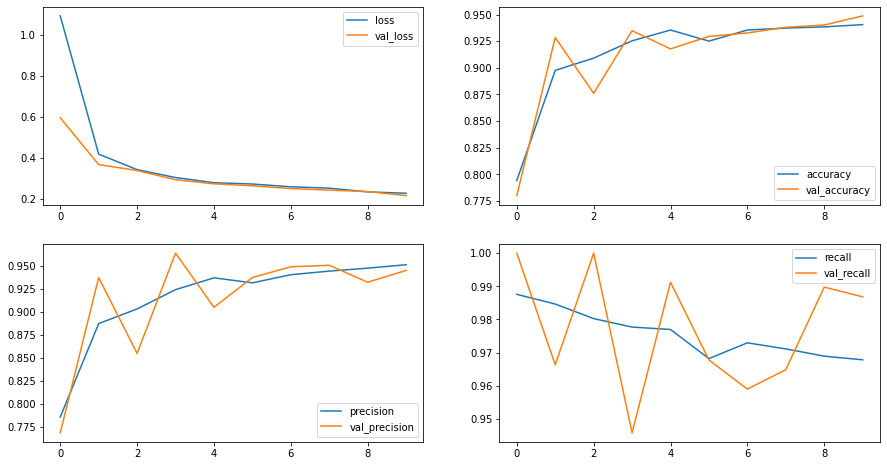

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn4_history.epoch, cnn4_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [53]:
y_pred = (cnn4_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 12s 387ms/step


Confusion matrix, without normalization
[[214  39]
 [  9 674]]


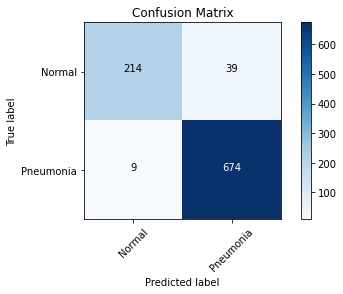

In [54]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [55]:
results = cnn4_model.evaluate(validation_generator)

1/1 [==============================] - 36s 36s/step - loss: 0.2153 - accuracy: 0.9487 - precision: 0.9453 - recall: 0.9868


In [56]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.2152545154094696
Model accuracy: 0.9487179517745972
Model precision: 0.9453015327453613
Model recall: 0.9868228435516357


Our accuracy increased fractionally from 94.7 to 94.8, while our precision fell from 98.3 to 94.5, and our recall increased from 94.4 to 98.6. We also still have a small amount of overfitting. Lets add a dropout layer onto our model to address this.

### CNN Model 5

In [57]:
cnn5_model = models.Sequential()
cnn5_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2, 2)))
cnn5_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2,2)))
cnn5_model.add(layers.Flatten())
cnn5_model.add(layers.Dense(16, activation='relu'))
cnn5_model.add(layers.Dropout(0.5))
cnn5_model.add(layers.Dense(1, activation='sigmoid'))

cnn5_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn5_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 39200)             0         
                                                                 
 dense_10 (Dense)            (None, 16)               

In [58]:
cnn5_history = cnn5_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 150s 1s/step - loss: 1.1718 - accuracy: 0.7253 - precision: 0.7294 - recall: 0.9912 - val_loss: 0.4807 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/10
118/118 [==============================] - 144s 1s/step - loss: 0.5194 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.3836 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/10
118/118 [==============================] - 148s 1s/step - loss: 0.4549 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.3525 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/10
118/118 [==============================] - 137s 1s/step - loss: 0.4452 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.3334 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 5/10
118/118 [==============================] - 143s 1s/step - loss: 0.4258 - accuracy: 0.7298

In [59]:
cnn5_model.save('models/cnn5')

INFO:tensorflow:Assets written to: models/cnn5/assets


INFO:tensorflow:Assets written to: models/cnn5/assets


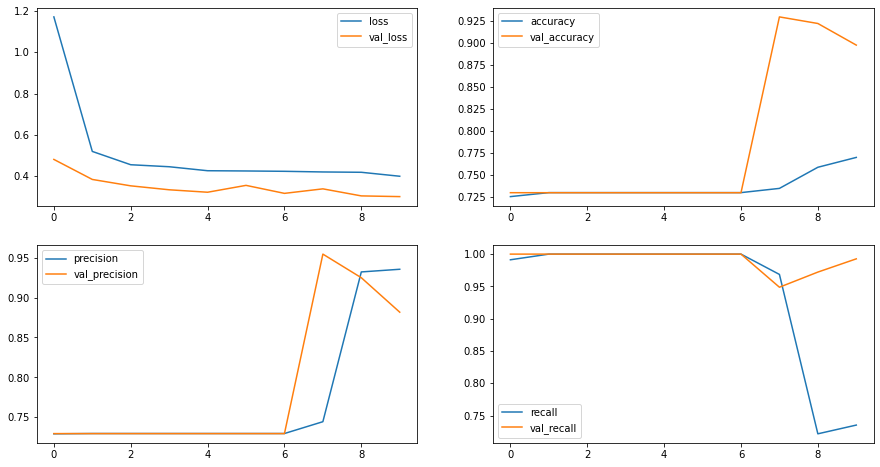

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn5_history.epoch, cnn5_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [61]:
y_pred = (cnn5_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 9s 306ms/step


Confusion matrix, without normalization
[[162  91]
 [  5 678]]


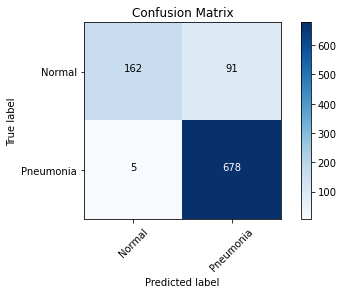

In [62]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [63]:
results = cnn5_model.evaluate(validation_generator)

1/1 [==============================] - 33s 33s/step - loss: 0.3003 - accuracy: 0.8974 - precision: 0.8817 - recall: 0.9927


In [64]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.3003063499927521
Model accuracy: 0.8974359035491943
Model precision: 0.881664514541626
Model recall: 0.9926793575286865


Our accuracy fell from 94.8 to 89.7, while our precision fell from 94.5 to 88.1, and our recall increased from 98.6 to 99.2. Let's see how adjusting the dropout layer from 0.5 to 0.3 affects the model.

### CNN Model 6

In [65]:
cnn6_model = models.Sequential()
cnn6_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2, 2)))
cnn6_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2,2)))
cnn6_model.add(layers.Flatten())
cnn6_model.add(layers.Dense(16, activation='relu'))
cnn6_model.add(layers.Dropout(0.3))
cnn6_model.add(layers.Dense(1, activation='sigmoid'))

cnn6_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn6_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 39200)             0         
                                                                 
 dense_12 (Dense)            (None, 16)               

In [66]:
cnn6_history = cnn6_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 139s 1s/step - loss: 1.0671 - accuracy: 0.7597 - precision: 0.7591 - recall: 0.9825 - val_loss: 0.4496 - val_accuracy: 0.8707 - val_precision: 0.8566 - val_recall: 0.9883
Epoch 2/25
118/118 [==============================] - 166s 1s/step - loss: 0.4310 - accuracy: 0.8725 - precision: 0.8789 - recall: 0.9572 - val_loss: 0.3722 - val_accuracy: 0.8579 - val_precision: 0.8387 - val_recall: 0.9971
Epoch 3/25
118/118 [==============================] - 156s 1s/step - loss: 0.3512 - accuracy: 0.8970 - precision: 0.9055 - recall: 0.9591 - val_loss: 0.3233 - val_accuracy: 0.9199 - val_precision: 0.9294 - val_recall: 0.9634
Epoch 4/25
118/118 [==============================] - 148s 1s/step - loss: 0.3355 - accuracy: 0.8992 - precision: 0.9208 - recall: 0.9430 - val_loss: 0.2926 - val_accuracy: 0.9145 - val_precision: 0.9058 - val_recall: 0.9854
Epoch 5/25
118/118 [==============================] - 150s 1s/step - loss: 0.3113 - accuracy: 0.9096

In [67]:
cnn6_model.save('models/cnn6')

INFO:tensorflow:Assets written to: models/cnn6/assets


INFO:tensorflow:Assets written to: models/cnn6/assets


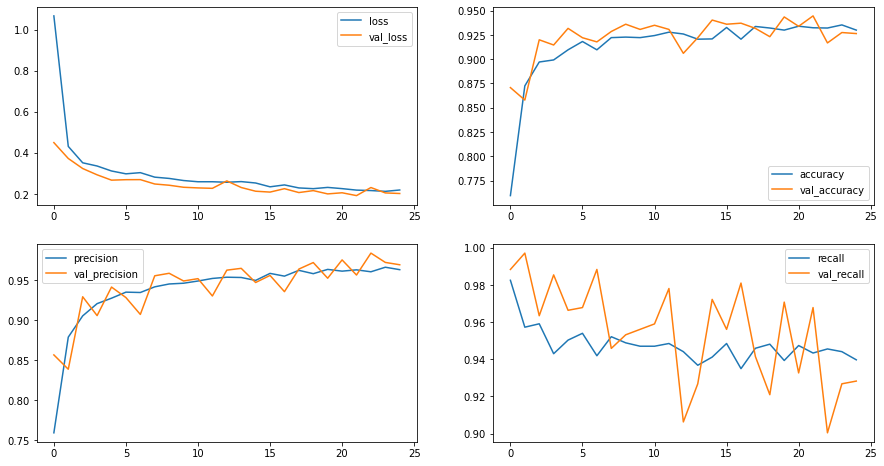

In [68]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn6_history.epoch, cnn6_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [69]:
y_pred = (cnn6_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 9s 312ms/step


Confusion matrix, without normalization
[[233  20]
 [ 49 634]]


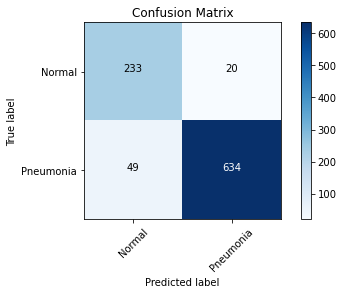

In [70]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [72]:
results = cnn6_model.evaluate(validation_generator)

1/1 [==============================] - 31s 31s/step - loss: 0.2015 - accuracy: 0.9263 - precision: 0.9694 - recall: 0.9283


In [73]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.2015143483877182
Model accuracy: 0.9262820482254028
Model precision: 0.9694189429283142
Model recall: 0.9282577037811279


Our accuracy increased from 89.7 to 92.6, while our precision increased from 88.1 to 96.9, and our recall fell from 99.2 to 92.8.  Let's adjust the strength of the regularizer from 0.05 to 0.025.

### CNN Model 7

In [74]:
cnn7_model = models.Sequential()
cnn7_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2, 2)))
cnn7_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2,2)))
cnn7_model.add(layers.Flatten())
cnn7_model.add(layers.Dense(16, activation='relu'))
cnn7_model.add(layers.Dropout(0.3))
cnn7_model.add(layers.Dense(1, activation='sigmoid'))

cnn7_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
cnn7_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 39200)             0         
                                                                 
 dense_14 (Dense)            (None, 16)               

In [75]:
cnn7_history = cnn7_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 161s 1s/step - loss: 0.7944 - accuracy: 0.7506 - precision: 0.7558 - recall: 0.9726 - val_loss: 0.4774 - val_accuracy: 0.8077 - val_precision: 0.7962 - val_recall: 0.9898
Epoch 2/25
118/118 [==============================] - 137s 1s/step - loss: 0.4221 - accuracy: 0.8714 - precision: 0.8734 - recall: 0.9635 - val_loss: 0.3409 - val_accuracy: 0.9092 - val_precision: 0.9199 - val_recall: 0.9590
Epoch 3/25
118/118 [==============================] - 166s 1s/step - loss: 0.3759 - accuracy: 0.8920 - precision: 0.9082 - recall: 0.9477 - val_loss: 0.3348 - val_accuracy: 0.9124 - val_precision: 0.9311 - val_recall: 0.9502
Epoch 4/25
118/118 [==============================] - 165s 1s/step - loss: 0.3365 - accuracy: 0.9061 - precision: 0.9227 - recall: 0.9510 - val_loss: 0.3009 - val_accuracy: 0.9145 - val_precision: 0.9170 - val_recall: 0.9707
Epoch 5/25
118/118 [==============================] - 187s 2s/step - loss: 0.3208 - accuracy: 0.9074

In [76]:
cnn7_model.save('models/cnn7')

INFO:tensorflow:Assets written to: models/cnn7/assets


INFO:tensorflow:Assets written to: models/cnn7/assets


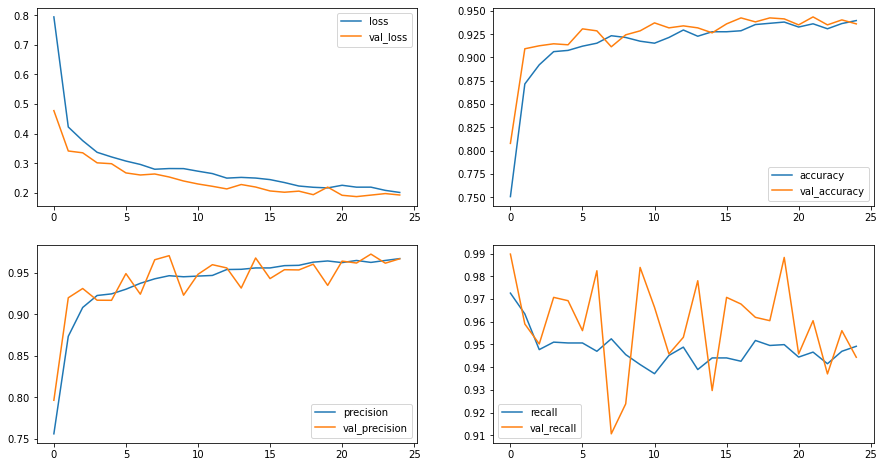

In [77]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn7_history.epoch, cnn7_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [78]:
y_pred = (cnn7_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 8s 279ms/step


Confusion matrix, without normalization
[[231  22]
 [ 38 645]]


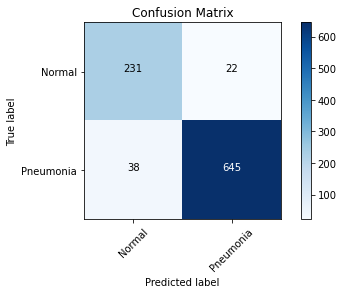

In [79]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [80]:
results = cnn7_model.evaluate(validation_generator)

1/1 [==============================] - 26s 26s/step - loss: 0.1921 - accuracy: 0.9359 - precision: 0.9670 - recall: 0.9444


In [81]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.19205224514007568
Model accuracy: 0.9358974099159241
Model precision: 0.9670165181159973
Model recall: 0.9443631172180176


Our accuracy increased from 92.6 to 93.5, while our precision dropped fractionally from 96.9  to 96.7, and our recall increased from 92.8 to 94.4. Let's adjust try adjusting the filter sizes of our Pooling layers.

### CNN Model 8

In [82]:

cnn8_model = models.Sequential()
cnn8_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Flatten())
cnn8_model.add(layers.Dense(16, activation='relu'))
cnn8_model.add(layers.Dropout(0.3))
cnn8_model.add(layers.Dense(1, activation='sigmoid'))

cnn8_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn8_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 7200)              0         
                                                                 
 dense_16 (Dense)            (None, 16)               

In [83]:
cnn8_history = cnn8_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 84s 694ms/step - loss: 0.7930 - accuracy: 0.7487 - precision: 0.7471 - recall: 0.9912 - val_loss: 0.4520 - val_accuracy: 0.8152 - val_precision: 0.7993 - val_recall: 0.9971
Epoch 2/25
118/118 [==============================] - 80s 681ms/step - loss: 0.4159 - accuracy: 0.8778 - precision: 0.8677 - recall: 0.9825 - val_loss: 0.3634 - val_accuracy: 0.9252 - val_precision: 0.9410 - val_recall: 0.9575
Epoch 3/25
118/118 [==============================] - 84s 708ms/step - loss: 0.3506 - accuracy: 0.9056 - precision: 0.9005 - recall: 0.9788 - val_loss: 0.3151 - val_accuracy: 0.9252 - val_precision: 0.9287 - val_recall: 0.9722
Epoch 4/25
118/118 [==============================] - 83s 704ms/step - loss: 0.3332 - accuracy: 0.9157 - precision: 0.9201 - recall: 0.9686 - val_loss: 0.2851 - val_accuracy: 0.9263 - val_precision: 0.9194 - val_recall: 0.9854
Epoch 5/25
118/118 [==============================] - 80s 678ms/step - loss: 0.3052 - accura

In [84]:
cnn8_model.save('models/cnn8')

INFO:tensorflow:Assets written to: models/cnn8/assets


INFO:tensorflow:Assets written to: models/cnn8/assets


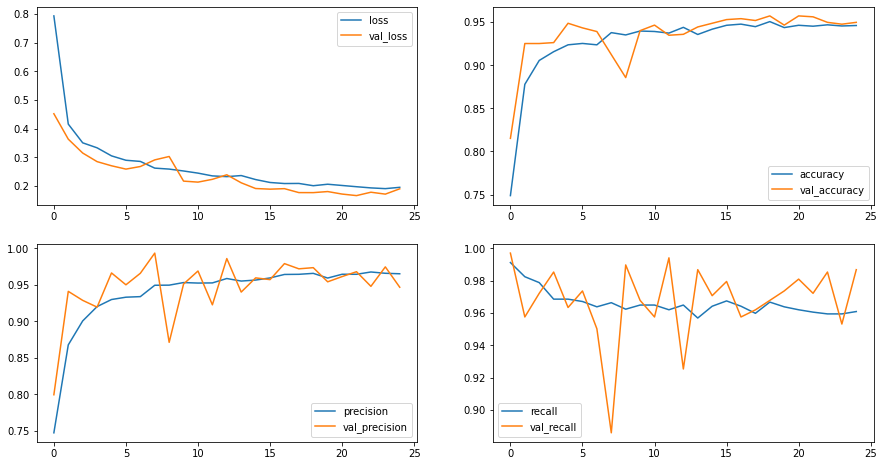

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn8_history.epoch, cnn8_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [86]:
y_pred = (cnn8_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 11s 353ms/step


Confusion matrix, without normalization
[[215  38]
 [  9 674]]


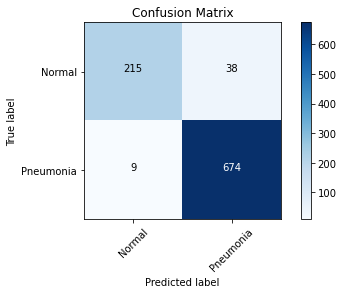

In [87]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [88]:
results = cnn8_model.evaluate(validation_generator)

1/1 [==============================] - 39s 39s/step - loss: 0.1904 - accuracy: 0.9498 - precision: 0.9466 - recall: 0.9868


In [89]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.1903574913740158
Model accuracy: 0.9497863054275513
Model precision: 0.9466292262077332
Model recall: 0.9868228435516357


Our accuracy increased from 93.5 to 94.9, while our precision dropped from 96.7 to 94.6, and our recall increased from 94.4 to 98.6. Let's adjust try adding another Pooling layer.

### CNN Model 9

In [90]:
cnn9_model = models.Sequential()
cnn9_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Flatten())
cnn9_model.add(layers.Dense(16, activation='relu'))
cnn9_model.add(layers.Dropout(0.3))
cnn9_model.add(layers.Dense(1, activation='sigmoid'))

cnn9_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn9_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 16)        

In [91]:
cnn9_history = cnn9_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 138s 1s/step - loss: 1.0978 - accuracy: 0.7157 - precision: 0.7323 - recall: 0.9620 - val_loss: 0.6641 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/25
118/118 [==============================] - 132s 1s/step - loss: 0.6389 - accuracy: 0.7295 - precision: 0.7298 - recall: 0.9993 - val_loss: 0.6090 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/25
118/118 [==============================] - 133s 1s/step - loss: 0.6114 - accuracy: 0.7317 - precision: 0.7314 - recall: 0.9993 - val_loss: 0.5819 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/25
118/118 [==============================] - 132s 1s/step - loss: 0.5732 - accuracy: 0.7421 - precision: 0.7451 - recall: 0.9828 - val_loss: 0.4764 - val_accuracy: 0.8686 - val_precision: 0.8784 - val_recall: 0.9517
Epoch 5/25
118/118 [==============================] - 130s 1s/step - loss: 0.4801 - accuracy: 0.8130

In [92]:
cnn9_model.save('models/cnn9')

INFO:tensorflow:Assets written to: models/cnn9/assets


INFO:tensorflow:Assets written to: models/cnn9/assets


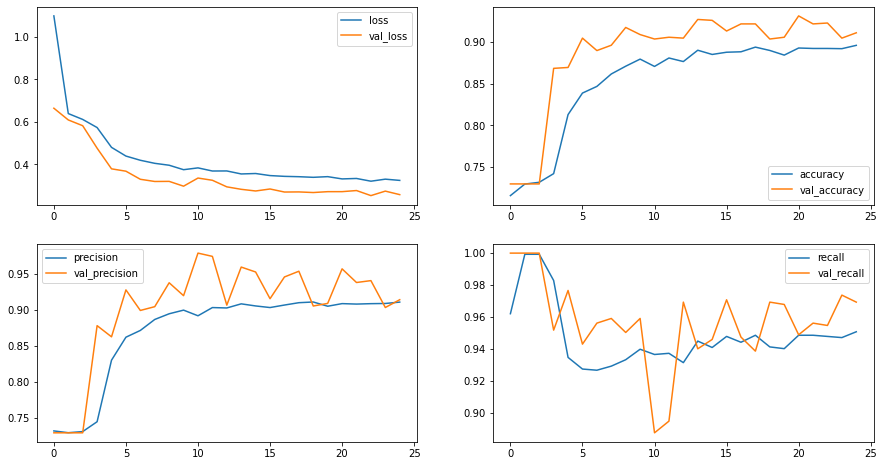

In [93]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn9_history.epoch, cnn9_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [94]:
y_pred = (cnn9_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 10s 329ms/step


Confusion matrix, without normalization
[[191  62]
 [ 21 662]]


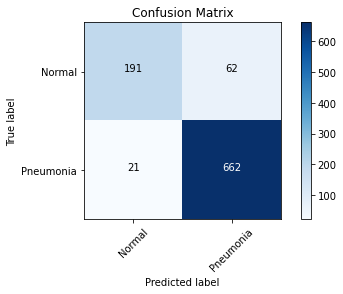

In [95]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [96]:
results = cnn9_model.evaluate(validation_generator)

1/1 [==============================] - 36s 36s/step - loss: 0.2580 - accuracy: 0.9113 - precision: 0.9144 - recall: 0.9693


In [97]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.25799328088760376
Model accuracy: 0.9113247990608215
Model precision: 0.9143646359443665
Model recall: 0.9692533016204834


Our accuracy fell significantly from 94.9 to 91.1, while our precision dropped from 94.6 to 91.4, and our recall decreased from 98.6 to 96.9. Let's adjust by trying to stop the model early - since there didnt seem to be more gain in the last 10-15 epochs.

### CNN Model 10

In [98]:
cnn10_model = models.Sequential()
cnn10_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Flatten())
cnn10_model.add(layers.Dense(16, activation='relu'))
cnn10_model.add(layers.Dropout(0.3))
cnn10_model.add(layers.Dense(1, activation='sigmoid'))

cnn10_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='max')

cnn10_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 16)       

In [99]:
cnn10_history = cnn10_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 136s 1s/step - loss: 1.0894 - accuracy: 0.7287 - precision: 0.7307 - recall: 0.9949 - val_loss: 0.6688 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/50
118/118 [==============================] - 124s 1s/step - loss: 0.6291 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.5732 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/50
118/118 [==============================] - 125s 1s/step - loss: 0.5081 - accuracy: 0.7733 - precision: 0.7774 - recall: 0.9660 - val_loss: 0.4016 - val_accuracy: 0.8771 - val_precision: 0.8737 - val_recall: 0.9722
Epoch 4/50
118/118 [==============================] - 118s 1s/step - loss: 0.4179 - accuracy: 0.8274 - precision: 0.8332 - recall: 0.9547 - val_loss: 0.3491 - val_accuracy: 0.9145 - val_precision: 0.9467 - val_recall: 0.9356
Epoch 5/50
118/118 [==============================] - 78s 656ms/step - loss: 0.3913 - accuracy: 0.84

In [100]:
cnn10_model.save('models/cnn10')

INFO:tensorflow:Assets written to: models/cnn10/assets


INFO:tensorflow:Assets written to: models/cnn10/assets


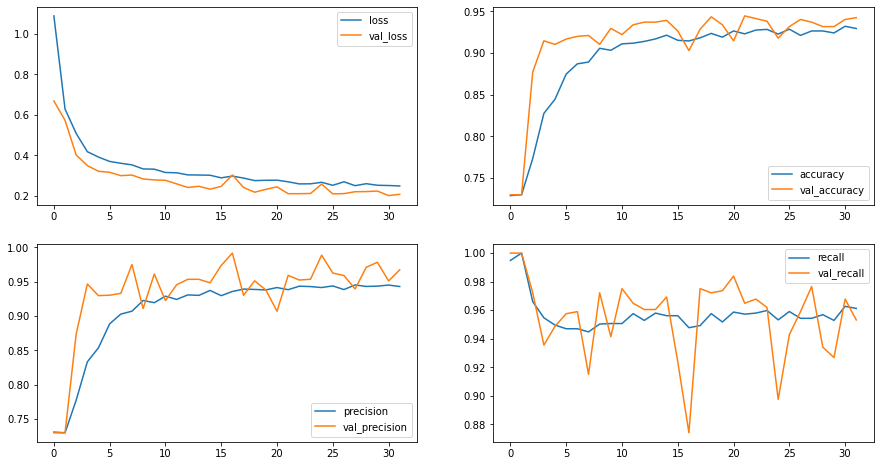

In [101]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn10_history.epoch, cnn10_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [102]:
y_pred = (cnn10_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 
 

30/30 [==============================] - 6s 202ms/step


Confusion matrix, without normalization
[[231  22]
 [ 32 651]]


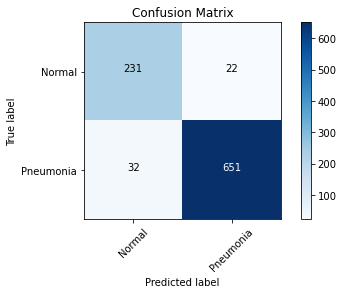

In [103]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [104]:
results = cnn10_model.evaluate(validation_generator)

1/1 [==============================] - 30s 30s/step - loss: 0.2072 - accuracy: 0.9423 - precision: 0.9673 - recall: 0.9531


In [105]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.20715223252773285
Model accuracy: 0.942307710647583
Model precision: 0.9673105478286743
Model recall: 0.9531478881835938


Our accuracy increased significantly from 91.1 to 94.2, our precision increased significantly from 91.4 to 96.7, and our recall decreased from 96.9 to 95.3. Let's adjust removing one of the Convolutional layers - reduced complexity of model.

### CNN Model 11

In [106]:
cnn11_model = models.Sequential()
cnn11_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Flatten())
cnn11_model.add(layers.Dense(16, activation='relu'))
cnn11_model.add(layers.Dropout(0.3))
cnn11_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn11_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn11_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 7200)              0         
                                                                 
 dense_22 (Dense)            (None, 16)              

In [107]:
cnn11_history = cnn11_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 85s 705ms/step - loss: 0.8226 - accuracy: 0.7266 - precision: 0.7302 - recall: 0.9920 - val_loss: 0.4616 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/50
118/118 [==============================] - 82s 699ms/step - loss: 0.4211 - accuracy: 0.8274 - precision: 0.8166 - recall: 0.9846 - val_loss: 0.3708 - val_accuracy: 0.7756 - val_precision: 0.7648 - val_recall: 1.0000
Epoch 3/50
118/118 [==============================] - 82s 698ms/step - loss: 0.3574 - accuracy: 0.8936 - precision: 0.8907 - recall: 0.9737 - val_loss: 0.3542 - val_accuracy: 0.9167 - val_precision: 0.9535 - val_recall: 0.9312
Epoch 4/50
118/118 [==============================] - 81s 690ms/step - loss: 0.3355 - accuracy: 0.9088 - precision: 0.9088 - recall: 0.9726 - val_loss: 0.2959 - val_accuracy: 0.9241 - val_precision: 0.9274 - val_recall: 0.9722
Epoch 5/50
118/118 [==============================] - 86s 726ms/step - loss: 0.3193 - accura

Epoch 37/50
118/118 [==============================] - 87s 736ms/step - loss: 0.1823 - accuracy: 0.9485 - precision: 0.9697 - recall: 0.9594 - val_loss: 0.1587 - val_accuracy: 0.9487 - val_precision: 0.9718 - val_recall: 0.9575
Epoch 38/50
118/118 [==============================] - 85s 723ms/step - loss: 0.1861 - accuracy: 0.9448 - precision: 0.9685 - recall: 0.9554 - val_loss: 0.1663 - val_accuracy: 0.9466 - val_precision: 0.9745 - val_recall: 0.9517
Epoch 39/50
118/118 [==============================] - 82s 696ms/step - loss: 0.1834 - accuracy: 0.9453 - precision: 0.9685 - recall: 0.9561 - val_loss: 0.1559 - val_accuracy: 0.9551 - val_precision: 0.9693 - val_recall: 0.9693
Epoch 40/50
118/118 [==============================] - 81s 687ms/step - loss: 0.1892 - accuracy: 0.9451 - precision: 0.9699 - recall: 0.9543 - val_loss: 0.1640 - val_accuracy: 0.9530 - val_precision: 0.9637 - val_recall: 0.9722
Epoch 41/50
118/118 [==============================] - 80s 680ms/step - loss: 0.1812 - a

In [108]:
cnn11_model.save('models/cnn11')

INFO:tensorflow:Assets written to: models/cnn11/assets


INFO:tensorflow:Assets written to: models/cnn11/assets


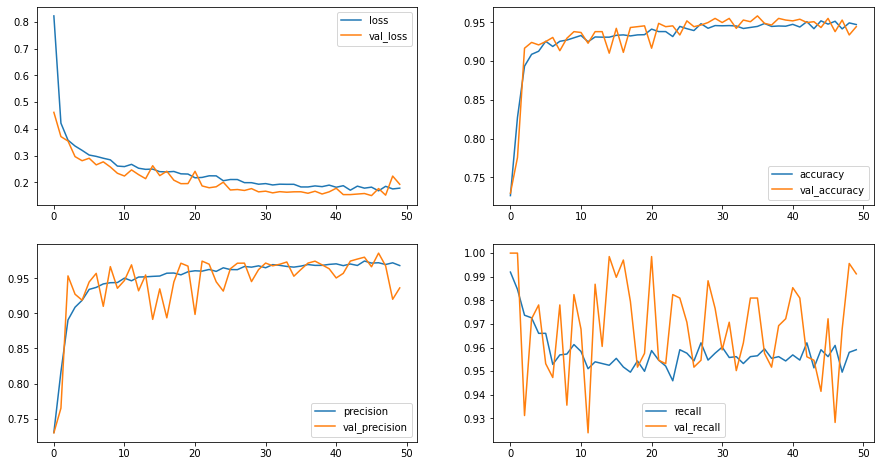

In [109]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn11_history.epoch, cnn11_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [110]:
y_pred = (cnn11_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 


30/30 [==============================] - 6s 201ms/step


Confusion matrix, without normalization
[[207  46]
 [  6 677]]


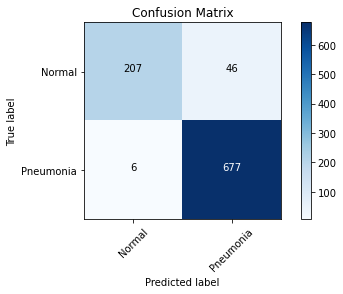

In [111]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [112]:
results = cnn11_model.evaluate(validation_generator)

1/1 [==============================] - 23s 23s/step - loss: 0.1923 - accuracy: 0.9444 - precision: 0.9364 - recall: 0.9912


In [113]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.19226549565792084
Model accuracy: 0.9444444179534912
Model precision: 0.9363762140274048
Model recall: 0.9912152290344238


Our accuracy increased fractionally from 94.2 to 94.4, our precision fell from 96.7 to 93.6, and our recall increased significantly from 95.3 to 99.1. Let's adjust removing one of the Convolutional layers - reduced complexity of model.

### CNN Model 12

In [114]:
cnn12_model = models.Sequential()
cnn12_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Flatten())
cnn12_model.add(layers.Dense(16, activation='relu'))
cnn12_model.add(layers.Dropout(0.3))
cnn12_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn12_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(name='precision', thresholds=0.3), metrics.Recall(name='recall', thresholds=0.3)]) 

cnn12_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 7200)              0         
                                                                 
 dense_24 (Dense)            (None, 16)              

In [115]:
cnn12_history = cnn12_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=30,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/30
118/118 [==============================] - 96s 800ms/step - loss: 0.7906 - accuracy: 0.7762 - precision: 0.7490 - recall: 0.9971 - val_loss: 0.3752 - val_accuracy: 0.8878 - val_precision: 0.8071 - val_recall: 0.9927
Epoch 2/30
118/118 [==============================] - 80s 679ms/step - loss: 0.3585 - accuracy: 0.8536 - precision: 0.8306 - recall: 0.9836 - val_loss: 0.2814 - val_accuracy: 0.9167 - val_precision: 0.8468 - val_recall: 0.9956
Epoch 3/30
118/118 [==============================] - 81s 686ms/step - loss: 0.3051 - accuracy: 0.9000 - precision: 0.8447 - recall: 0.9839 - val_loss: 0.2893 - val_accuracy: 0.9188 - val_precision: 0.9223 - val_recall: 0.9736
Epoch 4/30
118/118 [==============================] - 80s 681ms/step - loss: 0.2893 - accuracy: 0.9130 - precision: 0.8462 - recall: 0.9854 - val_loss: 0.2444 - val_accuracy: 0.9188 - val_precision: 0.9300 - val_recall: 0.9722
Epoch 5/30
118/118 [==============================] - 81s 687ms/step - loss: 0.2823 - accura

In [116]:
cnn12_model.save('models/cnn12')

INFO:tensorflow:Assets written to: models/cnn12/assets


INFO:tensorflow:Assets written to: models/cnn12/assets


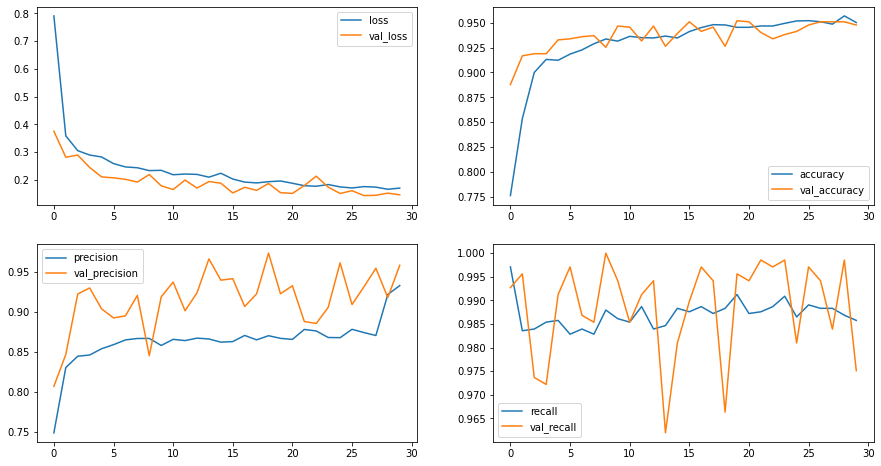

In [117]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn12_history.epoch, cnn12_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [118]:
y_pred = (cnn12_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 


30/30 [==============================] - 6s 204ms/step


Confusion matrix, without normalization
[[235  18]
 [ 31 652]]


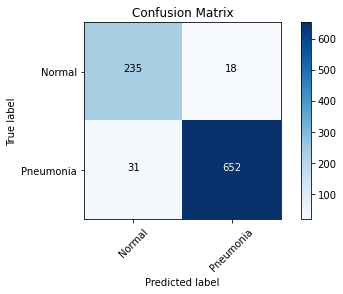

In [119]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [120]:
results = cnn12_model.evaluate(validation_generator)

1/1 [==============================] - 24s 24s/step - loss: 0.1460 - accuracy: 0.9476 - precision: 0.9583 - recall: 0.9751


In [121]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.14602766931056976
Model accuracy: 0.9476495981216431
Model precision: 0.9582734107971191
Model recall: 0.9751098155975342


Our accuracy increased fractionally from 94.4 to 94.7, our precision increased from 93.6 to 95.8, and our recall fell  from 99.1 to 97.5.

Overall all of our CNN models had similar metrics. Loss was under 0.3 for all our models, while accuracy, precision and recall were all above 88%. Ultimately we chose Model 11 as our best performing model - it had a higher recall score and high accuracy and precision.

## Final Model
Ultimately recall was the metric we were most concerned about - identifying all the diagnosed cases of pneumonia. So we chose the model that gave us the best recall -99.1%. Now we will evaluate the the model using our test data.

In [122]:
results = cnn11_model.evaluate(test_generator)

1/1 [==============================] - 33s 33s/step - loss: 0.2007 - accuracy: 0.9539 - precision: 0.9501 - recall: 0.9873


In [123]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.20068132877349854
Model accuracy: 0.9539295434951782
Model precision: 0.9500609040260315
Model recall: 0.9873417615890503


In [124]:
y_pred = (cnn11_model.predict(test_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= test_labels, y_pred=y_pred) 

35/35 [==============================] - 15s 426ms/step


Confusion matrix, without normalization
[[276  41]
 [ 10 780]]


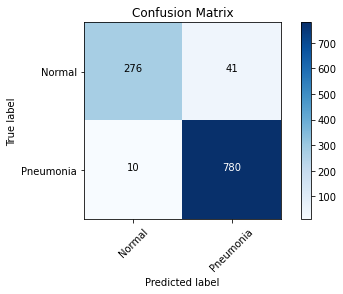

In [126]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

Our final model results - give us an accuracy score of 95.3%, a precision score of 95%, and a recall score of 98.7%. This means our false negative rate - is 1.3%. Out of 100 children who have pneumonia, our model will identify all but 1 child. 
![](Images/simplewaffleplot.png)

## Modeling and Results
In this project, we're trying to identify whether the input image is pneumonia or not. We built several Convolutional Neural Network (CNN) models to make the classification. We trained our model with training data and validated our models using validation data. Then based on the validation score, we choose our best model and ran that best model with testing data to get our final result. We built 12 CNN models in this project and among all the models, our 11th CNN had the best training and validation score when looking at accuracy and recall. So we used this model as our best model and ran the test using testing data. Our best model achieved 95.3 % accuracy and 98.7% recall on unseen test data. This recall score means that for every 50 X-Ray images belonging to patients with pneumonia, our model only misclassifies less than one of these images, which is very good. 

## Conclusion & Next Steps
In conclusion, our best model did very well at identifying the pneumonia images with 94.4 % accuracy and 99.1% recall. We care most about the recall score because this represents how well our model does at predicting the class of images belonging to those with pneumonia. Given our business case, false negatives (patient has pneumonia but we classify them as healthy) are much more dangerous than false positives (patient is healthy but we classify them as having pneumonia).

As for some potential next steps, we can work with the WHO to deploy our model in the real world, specifically in areas hardest hit by pneumonia among young children. Based on our findings, we recommend the World Health Organization deploy our model by investing and dispatching mobile xray vans. These are vans that have the capability to take xrays inside the van. We also recommend stocking these vans with vaccines and treatment medications. These vans will make healthcare more readily accessible and offer a sort of one stop shop - prevention, diagnosis and treatment. 

Meanwhile, we can keep tuning our model based on the feedback in order to improve our recall. Plus, there are many pre-trained neural network models already available online, so we can run our data on those models and make some improvements to our model by comparing our model with those pre-trained models. Lastly, we don't have strong background knowledge on identifying Pneumonia from an X-Ray image, so it is necessary to tackle this issue with domain experts and consult them on questions such as, what features in an X-Ray image that our model misclassified could a radiologist point out to modify our model.
